In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

2022-09-07 10:14:56.273720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
image_path = "/data/ai_hub/"
print(os.listdir(image_path))
image_dir_list = [image_path+F for F in [directory for directory in os.listdir(image_path) if not directory.endswith(".zip")]]
print(image_dir_list)

['EMOIMG.zip', '[원천]EMOIMG_슬픔_VALID', 'Raw_EMOIMG_0629.zip', '[원천]EMOIMG_분노_VALID', '[원천]EMOIMG_당황_VALID', 'Raw_EMOIMG_0629_2.zip', '[원천]EMOIMG_상처_VALID', '[원천]EMOIMG_기쁨_VALID.zip', '[원천]EMOIMG_기쁨_VALID', '[원천]EMOIMG_불안_VALID', 'labels.txt', '[원천]EMOIMG_중립_VALID']
['/data/ai_hub/[원천]EMOIMG_슬픔_VALID', '/data/ai_hub/[원천]EMOIMG_분노_VALID', '/data/ai_hub/[원천]EMOIMG_당황_VALID', '/data/ai_hub/[원천]EMOIMG_상처_VALID', '/data/ai_hub/[원천]EMOIMG_기쁨_VALID', '/data/ai_hub/[원천]EMOIMG_불안_VALID', '/data/ai_hub/labels.txt', '/data/ai_hub/[원천]EMOIMG_중립_VALID']


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [4]:
flowers_dir = os.path.join("/data/carescope_data/")
flowers_dir

'/data/carescope_data/'

In [5]:
import splitfolders

In [6]:
splitfolders.ratio("/data/caer_img_data/",
                   output = "/data/splited/",
                   ratio = (0.8, 0.1, 0.1))

Copying files: 22394 files [05:41, 65.50 files/s] 


In [4]:
# Augmentation 없이 데이터 stream
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_path = "/data/splited/train"
valid_path = "/data/splited/val"

train_generator = datagen.flow_from_directory(
    train_path,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "training"
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "validation"
)

Found 14333 images belonging to 3 classes.
Found 447 images belonging to 3 classes.


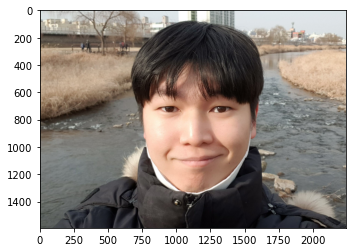

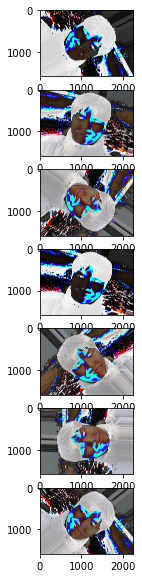

In [105]:
#@ Image Augmentaion 
image_path = os.path.join('/data/splited/test',
                          '[원천]EMOIMG_기쁨_VALID')
sample_name = random.choice(os.listdir(image_path))
img = load_img(f"{image_path}/{sample_name}")
plt.imshow(img)
plt.show()
x = img_to_array(img)
x = x[np.newaxis, ...]
augmentator = ImageDataGenerator(rescale=1.0, # 축소
                                 rotation_range=90, # 회전
#                                  width_shift_range=0.1, # 가로 변형
#                                  height_shift_range=0.2, # 세로변형
#                                  zoom_range=0.3, # 줌
                                 zca_whitening=True,
                                 zca_epsilon=1e-06,
                                 cval=1.,
                                 horizontal_flip=True, # 수평 반전
                                 vertical_flip=True,  # 수직 반전
                                 brightness_range=[0.3, 1], # 밝기 변형
                                 channel_shift_range=4.9, # 채널(?) 변형
                                 shear_range=0.05, # ???
                                 featurewise_center=True, # 중심 영역 유지(?)
                                 featurewise_std_normalization=False,
                                 samplewise_std_normalization=False,
                                 samplewise_center=True,
                                 preprocessing_function = None)
gen = augmentator.flow(x, batch_size=1)
plt.figure(figsize=(10,10))
for i in range(7):
    plt.subplot(7,1, i+1)
    batch = gen.next()
    img = batch[0].astype('uint8')
    plt.imshow(img)
    # save_img(f"img_test.jpg",x=img)
plt.show()

In [7]:
# Augmentation 데이터 stream
augmentator = ImageDataGenerator(rescale=0.8,
                                 rotation_range=15,
                                 width_shift_range=0.1,
                                 height_shift_range=0.2,
                                 zoom_range=0.3,
                                 horizontal_flip=True,
                                 brightness_range=[0.2, 1],
                                 channel_shift_range=0.2,
                                 shear_range=0.4,
                                 vertical_flip=True,
                                 featurewise_center=True,
                                 samplewise_center=False,)

train_generator = augmentator.flow_from_directory(
    flowers_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "training")

valid_generator = augmentator.flow_from_directory(
    flowers_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "validation")

Found 22413 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [8]:
print("\n".join(sorted(train_generator.class_indices.keys())))

[원천]EMOIMG_기쁨_VALID
[원천]EMOIMG_슬픔_VALID
[원천]EMOIMG_중립_VALID


In [9]:
label_keys = \
    [key.replace("[원천]EMOIMG_","").replace("_VALID","") for key in train_generator.class_indices.keys()]
label_values = train_generator.class_indices.values()
train_generator.class_indices = dict(zip(label_keys, label_values))
valid_generator.class_indices = dict(zip(label_keys, label_values))

In [10]:
train_generator.class_indices.keys(), valid_generator.class_indices.keys()

(dict_keys(['기쁨', '슬픔', '중립']), dict_keys(['기쁨', '슬픔', '중립']))

In [11]:
with open('/data/ai_hub/labels.txt', "w") as f:
    f.write("\n".join(sorted(train_generator.class_indices.keys())))
    f.close()

In [12]:
!cat /data/ai_hub/labels.txt

기쁨
슬픔
중립

In [14]:
image_batch, label_batch = next(valid_generator)
image_batch.shape, label_batch.shape

((0, 224, 224, 3), (0, 3))

In [17]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                          include_top=False,
                                          weights="imagenet")

In [18]:
# mobilenet 동결
model.trainable = False

In [19]:
# mobilenet 100개 layer 까지만 동결
model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

In [20]:
classifier = tf.keras.Sequential([
    model,
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=6, activation="softmax")
])

In [21]:
classifier.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
print(len(classifier.trainable_weights))

58


In [23]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 2,626,854
Trainable params: 2,230,310
Non-trainable params: 396,544
_________________________________________________________________


In [24]:
# 다른 mobilenet 구조 파라미터
tf.keras.models.load_model("weights/MobileFaceNet_48_1_0-06.hdf5").summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 50, 50, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 64)        1728      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 64)        256       
_________________________________________________________________
conv1_relu (LeakyReLU)       (None, 24, 24, 64)        0         
_________________________________________________________________
conv_dw_0 (DepthwiseConv2D)  (None, 24, 24, 64)        576       
_________________________________________________________________
conv_dw_0_bn (BatchNormaliza (None, 24, 24, 64)        256   

In [5]:
!nvidia-smi

Wed Sep  7 10:15:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |    248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:07.0 Off |                    0 |
| N/A   

In [6]:
import tensorflow as tf
tf.config.experimental.list_logical_devices()

2022-09-07 10:15:04.350440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-07 10:15:04.352165: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-07 10:15:04.374475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-07 10:15:04.375735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-07 10:15:04.376955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:00:08.0 name: Tesla T4 computeCapability: 

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:GPU:2', device_type='GPU'),
 LogicalDevice(name='/device:GPU:3', device_type='GPU')]

low/core/common_runtime/gpu/gpu_device.cc:1720] Found device 3 with properties: 
pciBusID: 0000:00:09.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-07 10:15:04.378182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-07 10:15:04.386447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-07 10:15:04.386537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-09-07 10:15:04.430510: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-09-07 10:15:04.431460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-09-07 10:15:04.442212: I tensorflow

In [7]:
# multi GPU 병렬 연산
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [32]:
IMAGE_SIZE = 224
BATCH_SIZE = 128
OUTPUT_SIZE = 3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, OUTPUT_SIZE)

def get_model(input_shape, outputs):
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet")

    # mobilenet 100개 layer 까지만 동결
    # model.trainable = False
    # fine_tune_at = 100

    # # Freeze all the layers before the `fine_tune_at` layer
    # for layer in model.layers[:fine_tune_at]:
    #     layer.trainable =  False
        
    classifier = tf.keras.Sequential([
        model,
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=outputs, activation="swish"),
        tf.keras.layers.SpatialDropout2D(rate=0.2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=outputs, activation="softmax")
    ])
    classifier.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
#         jit_compile=None, # XLA 환경에서 실행할 때
    )

    return classifier

In [102]:
get_model(input_shape=INPUT_SHAPE,
          outputs=OUTPUT_SIZE).summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 9, 9, 64)          589888    
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 9, 9, 64)          0         
_________________________________________________________________
global_average_pooling2d_15  (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 195       
Total params: 2,120,051
Trainable params: 2,107,939
Non-trainable params: 12,112
_________________________________________________________________


In [34]:
# training!
base_path = "/data/splited/"
train_dir = os.path.join(base_path + "train")
valid_dir = os.path.join(base_path + "val")
test_dir = os.path.join(base_path + "test")

augmentator = ImageDataGenerator(
                            rescale=0.8,
                            rotation_range=90,
#                             width_shift_range=0.1,
#                             height_shift_range=0.2,
#                             zoom_range=0.3,
                            horizontal_flip=True,
                            brightness_range=[0.2, 1],
                            channel_shift_range=0.2,
                            shear_range=0.4,
                            vertical_flip=True,
                            featurewise_center=True,
#                             samplewise_center=False,
                            validation_split=0.2,
        )

train_generator = augmentator.flow_from_directory(
    train_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "training")

valid_generator = augmentator.flow_from_directory(
    valid_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "validation")

test_generator = augmentator.flow_from_directory(
    test_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "validation")

with strategy.scope():
    classifier = get_model(input_shape=INPUT_SHAPE,
                           outputs=OUTPUT_SIZE)
    classifier.summary()

Found 14333 images belonging to 3 classes.
Found 447 images belonging to 3 classes.
Found 447 images belonging to 3 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 9, 9, 32)          294944    
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 9, 9, 32)          0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,825,011
Trainable params: 1,812,899
Non-trainable params: 12,112
______________________________________________

In [13]:
!sudo rm -rdf weights/checkpoints

In [37]:
import os
import warnings
import tensorflow as tf
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings(action='ignore')

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights/checkpoints",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    monitor='val_accuracy',
    mode='max')

history = classifier.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[es_callback,
               model_checkpoint_callback]    
)

2022-09-13 09:52:53.648864: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2056935"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
  

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8884

2022-09-13 10:06:36.434823: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2057661"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
  

112/112 [==============================] - 848s 8s/step - loss: 0.2780 - accuracy: 0.8884 - val_loss: 0.5175 - val_accuracy: 0.8121

Epoch 00001: val_accuracy improved from -inf to 0.81208, saving model to weights/checkpoints
Epoch 2/100
112/112 [==============================] - 819s 7s/step - loss: 0.2760 - accuracy: 0.8865 - val_loss: 0.5081 - val_accuracy: 0.8121

Epoch 00002: val_accuracy did not improve from 0.81208
Epoch 3/100
112/112 [==============================] - 817s 7s/step - loss: 0.2677 - accuracy: 0.8930 - val_loss: 0.4981 - val_accuracy: 0.8143

Epoch 00003: val_accuracy improved from 0.81208 to 0.81432, saving model to weights/checkpoints
Epoch 4/100
112/112 [==============================] - 813s 7s/step - loss: 0.2639 - accuracy: 0.8919 - val_loss: 0.4873 - val_accuracy: 0.8166

Epoch 00004: val_accuracy improved from 0.81432 to 0.81655, saving model to weights/checkpoints
Epoch 5/100
112/112 [==============================] - 818s 7s/step - loss: 0.2599 - accurac

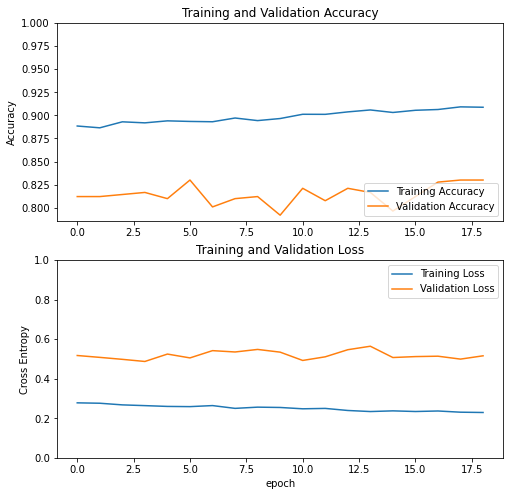

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
model_file_name = 'mobilenet_v2_1.0_230'

In [40]:
saved_clf = get_model(input_shape=INPUT_SHAPE,
                     outputs=OUTPUT_SIZE)

In [41]:
saved_clf = tf.keras.models.load_model("weights/checkpoints/")

In [ ]:
saved_clf.load_weights("check", by_name=False, skip_mismatch=False)

In [44]:
# classifier.save_weights("check")

In [42]:
# tflite 그냥 변환
saved_clf = tf.keras.models.load_model("weights/checkpoints")
converter = tf.lite.TFLiteConverter.from_keras_model(saved_clf)
tflite_model = converter.convert()

with open(model_file_name+".tflite", 'wb') as f:
  f.write(tflite_model)
  print(f"Model weight file({model_file_name+'.tflite'}) created")

2022-09-13 14:14:30.132869: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-09-13 14:14:30.133172: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-09-13 14:14:30.133570: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-13 14:14:30.134466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-13 14:14:30.135211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-13 14:14:30.135898: I tensorflow/core/common_runtime/gpu/g

Model weight file(mobilenet_v2_1.0_230.tflite) created


2022-09-13 14:14:31.318854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-09-13 14:14:31.318909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


In [43]:
# 파라미터 양자화 후 변환
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(base_path + 'train/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(saved_clf)
# # This enables quantization
# # converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# # This sets the representative dataset for quantization
# converter.representative_dataset = representative_data_gen
# # This ensures that if any ops can't be quantized, the converter throws an error
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
# converter.target_spec.supported_types = [tf.int8]
# # These set the input and output tensors to uint8 (added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(model_file_name+"_quant.tflite", 'wb') as f:
  f.write(tflite_model)
  print(f"Model weights({model_file_name+'_quant.tflite'}) quantized")

2022-09-13 14:14:50.450874: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-09-13 14:14:50.451045: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-09-13 14:14:50.451470: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-13 14:14:50.452312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-13 14:14:50.453056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-13 14:14:50.453762: I tensorflow/core/common_runtime/gpu/g

Model weights(mobilenet_v2_1.0_230_quant.tflite) quantized


2022-09-13 14:14:51.474058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-09-13 14:14:51.474115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-09-13 14:14:51.814401: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor sequential_4/MobilenetV3small/Conv/BatchNorm/FusedBatchNormV3;sequential_4/MobilenetV3small/expanded_conv/project/Conv2D;sequential_4/MobilenetV3small/Conv/Conv2D1 because it has fewer than 1024 elements (432).
2022-09-13 14:14:51.814452: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor sequential_4/MobilenetV3small/expanded_conv/depthwise/BatchNorm/FusedBatchNormV3;sequential_4/MobilenetV3small/expanded_conv/depthwise/depthwise;sequential_4/MobilenetV3small/expanded_conv/project/Conv2D because it has fewer than 1024 elements (144).
2022-09-13 14:14:51.814460: I tensorflow/lit

In [44]:
batch_images, batch_labels = next(test_generator)

logits = saved_clf(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

2022-09-13 14:15:02.827393: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-09-13 14:15:03.515362: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-09-13 14:15:04.191755: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-09-13 14:15:04.919515: W tensorflow/stream_executor/gpu/

Raw model accuracy: 85.938%


2022-09-13 14:15:10.586771: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



In [45]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input )#/ scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
#   output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter(model_file_name+"_quant.tflite")
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in tqdm(range(len(batch_images))):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))
print(classification_report(batch_prediction, batch_truth))

100%|██████████| 128/128 [00:29<00:00,  4.36it/s]

Quant TF Lite accuracy: 80.469%
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        45
           1       0.74      0.81      0.78        43
           2       0.79      0.75      0.77        40

    accuracy                           0.80       128
   macro avg       0.81      0.80      0.80       128
weighted avg       0.81      0.80      0.81       128



In [47]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
interpreter = tf.lite.Interpreter("mobilenet_v2_1.0_230"+".tflite")
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in tqdm(range(len(batch_images))):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))
print(classification_report(batch_prediction, batch_truth))

100%|██████████| 128/128 [00:04<00:00, 30.97it/s]

TF Lite accuracy: 85.938%
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        47
           1       0.74      0.92      0.82        38
           2       0.89      0.79      0.84        43

    accuracy                           0.86       128
   macro avg       0.86      0.86      0.86       128
weighted avg       0.87      0.86      0.86       128

